# 데이터 전처리 및 Feature 구성 요약

#### 데이터 파일
- **파일명**: `kkbox_train_feature_v2.parquet`
- **전체 컬럼 수**: 88개 (msno, is_churn 포함)
- **학습용 피처 수**: 86개

---

#### Feature 타입 구성
- 수치형 feature 개수: 82개
- 범주형 feature 개수: 4개 (`gender`, `city`, `registered_via`, `last_payment_method`)

---

#### 전처리 단계 (컬럼 정리)

- 중복 컬럼 제거 완료:
  - `recency_secs_ratio` = `secs_trend_w7_w30` → **제거됨**
  - `recency_songs_ratio` = `songs_trend_w7_w30` → **제거됨**

- 시간 관련 컬럼:
  - `registration_init_time`: 가입 시각 (datetime)
  - `registration_month`: 가입 월
  - `days_since_last_payment`: 마지막 결제 후 경과일
  - `days_since_last_cancel`: 마지막 취소 후 경과일

---

#### 결측치 처리

- User Logs 피처: 0으로 대체 (활동 없음)
- Transaction count/amount: 0으로 대체
- Transaction flags: 명시적 값 지정 (`is_free_user` → 1)
- `bd_clean`: NaN 유지 (LightGBM/CatBoost 자체 처리)

---

#### 전처리 결과 Feature 차원 확인

- 최종 feature 개수: **86개** (학습용)
- Feature 구성:
  - **User Log 기반 (윈도우별)**: 56개 (4윈도우 × 14피처)
  - **User Log 추세 피처**: 8개
  - **Transaction 기반**: 15개
  - **Member 기반**: 7개


# 데이터 분할 설정

- 분할 방식:
  - Stratified random split (`stratify = is_churn`)
  - `random_state = 719`

- 분할 비율:
  - Train: 70% (602,676 × 86)
  - Validation: 15% (129,145 × 86)
  - Test: 15% (129,145 × 86)

- 전체 샘플 수: **860,966명**

- 분할 기준:
  - user-level feature table 기준
  - 각 행은 고유 사용자(msno)를 나타냄

- 클래스 불균형:
  - Churn 비율: 약 9.46% (81,448명)
  - Non-Churn 비율: 약 90.54% (779,518명)


# CatBoost Hyperparameters

- 모델: `catboost.CatBoostClassifier`

- 하이퍼파라미터:
  - `loss_function`: "Logloss"
  - `eval_metric`: "AUC"
  - `learning_rate`: 0.05
  - `depth`: 6
  - `l2_leaf_reg`: 3.0
  - `iterations`: 500
  - `early_stopping_rounds`: 50
  - `scale_pos_weight`: 15.18 (Recall 최적화용)
  - `random_seed`: 719
  - `thread_count`: -1

- 학습 결과:
  - `best_iteration`: (재학습 후 업데이트 필요)


# Score (valid/test)


C:\Users\WORK\AppData\Local\Temp\ipykernel_9672\3886394223.py:43: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\WORK\AppData\Local\Temp\ipykernel_9672\3886394223.py:43: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\WORK\AppData\Local\Temp\ipykernel_9672\3886394223.py:43: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\WORK\anaconda3\envs\project-2nd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\WORK\anaconda3\envs\project-2nd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\WORK\anaconda3\envs\project-2nd\Lib\site-packages\IPython\core\pyla

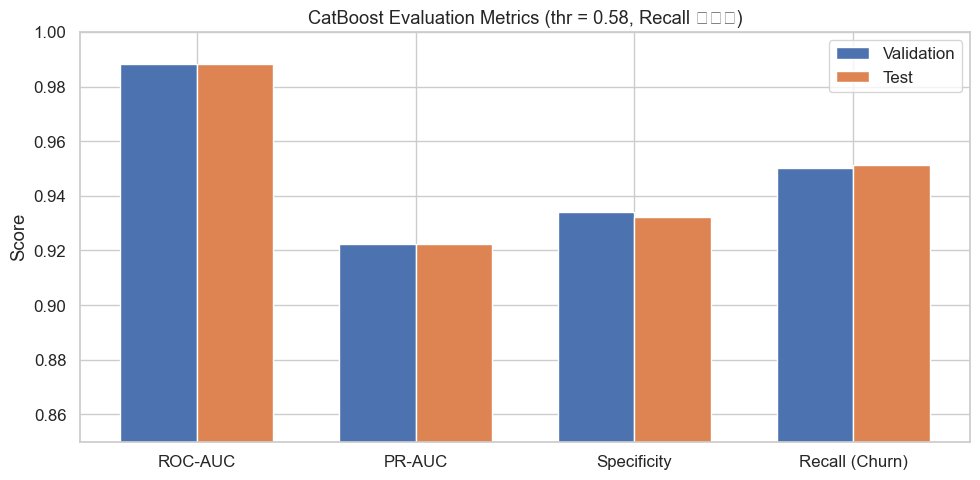

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 (threshold = 0.58 최적화 기준)
metrics_df = pd.DataFrame({
    "dataset": ["Validation", "Test"],
    "ROC-AUC": [0.9881, 0.9883],
    "PR-AUC":  [0.9224, 0.9222],
    "Specificity": [0.9341, 0.9324],
    "Recall (Churn)": [0.9501, 0.9514],
})

# long format 변환
metrics_long = metrics_df.melt(
    id_vars="dataset",
    var_name="metric",
    value_name="score",
)

# Bar plot
plt.figure(figsize=(10, 5))

for i, dataset in enumerate(metrics_long["dataset"].unique()):
    subset = metrics_long[metrics_long["dataset"] == dataset]
    x = range(len(subset))
    plt.bar(
        [v + i * 0.35 for v in x],
        subset["score"],
        width=0.35,
        label=dataset,
    )

plt.xticks(
    [v + 0.175 for v in range(len(subset))],
    subset["metric"],
    rotation=0,
)

plt.ylim(0.85, 1.0)
plt.ylabel("Score")
plt.title("CatBoost Evaluation Metrics (thr = 0.58, Recall 최적화)")
plt.legend()
plt.tight_layout()
plt.show()


# Confusion matrix (valid/test)


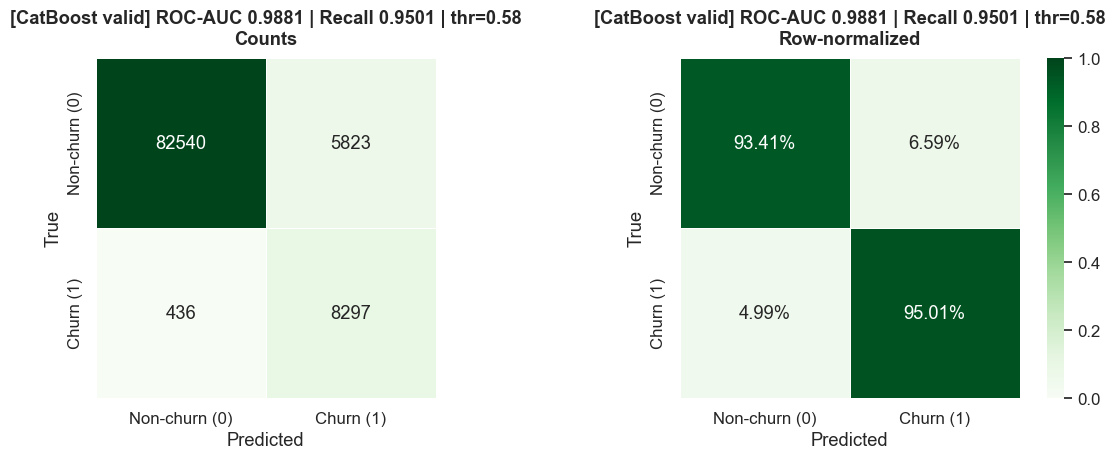

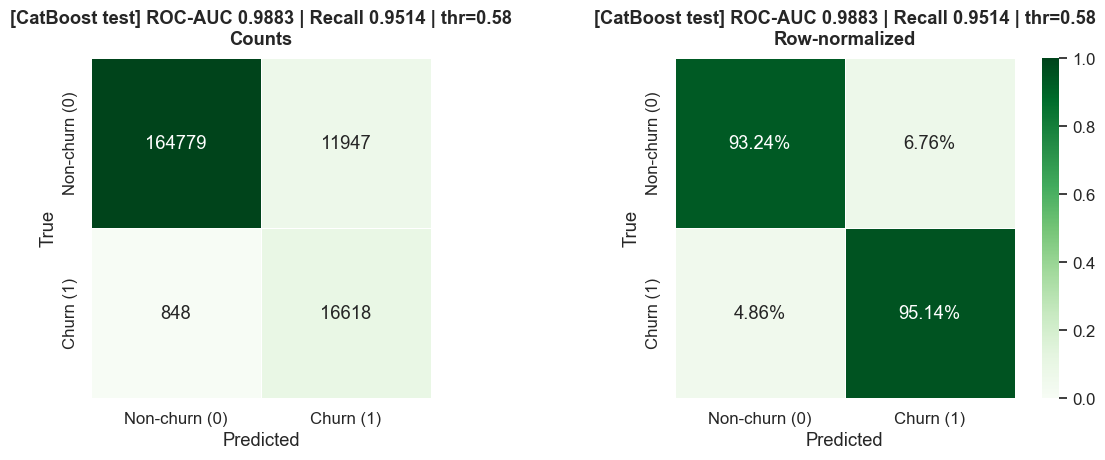

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(
    cm: np.ndarray,
    title: str,
    labels=("Non-churn (0)", "Churn (1)"),
):
    """
    cm: shape (2,2) confusion matrix in form:
        [[TN, FP],
         [FN, TP]]
    """
    sns.set_theme(style="white", font_scale=1.1)

    cm = np.array(cm, dtype=int)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)  # row-normalized

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

    # --- (1) Raw counts ---
    ax = axes[0]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        cbar=False,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_title(f"{title}\nCounts", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # --- (2) Row-normalized (recall view) ---
    ax = axes[1]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2%",
        cmap="Greens",
        cbar=True,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"{title}\nRow-normalized", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()


# =========================
# Confusion matrices (threshold = 0.58)
# =========================
cm_valid = np.array([[82540, 5823],
                     [  436, 8297]])

cm_test  = np.array([[164779, 11947],
                     [   848, 16618]])

plot_confusion_matrices(
    cm_valid,
    title="[CatBoost valid] ROC-AUC 0.9881 | Recall 0.9501 | thr=0.58",
)

plot_confusion_matrices(
    cm_test,
    title="[CatBoost test] ROC-AUC 0.9883 | Recall 0.9514 | thr=0.58",
)


# Feature Importances (Top 20)


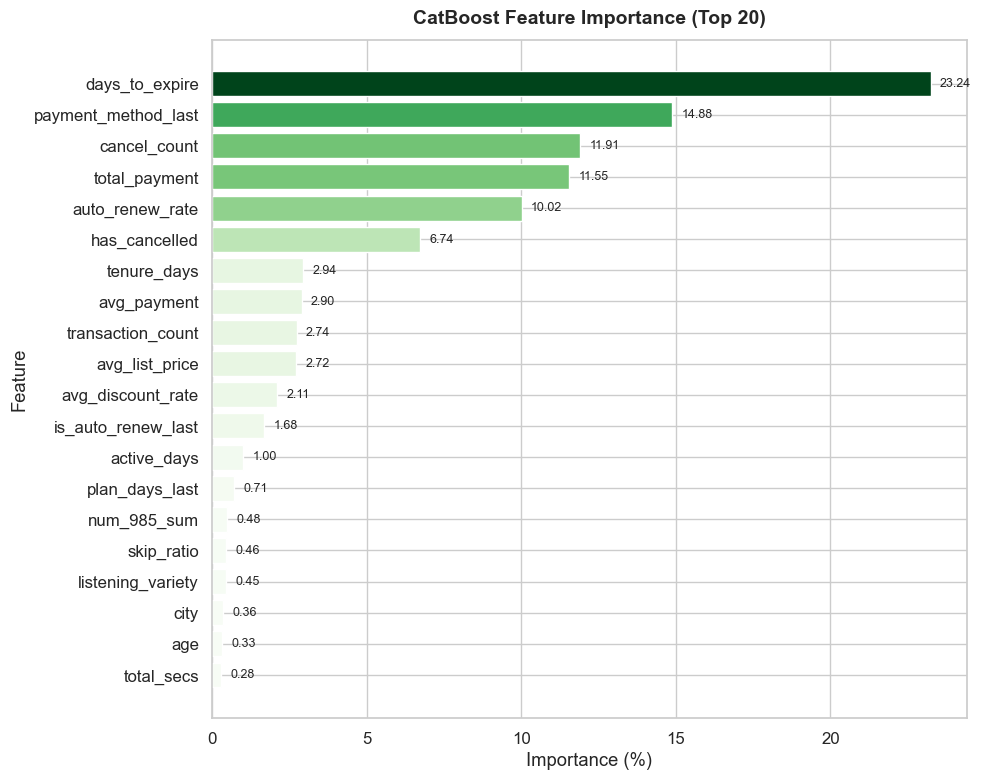

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# ===============================
# CatBoost Feature Importance Data
# ===============================
fi_data = [
    {"feature": "days_to_expire", "importance": 23.24},
    {"feature": "payment_method_last", "importance": 14.88},
    {"feature": "cancel_count", "importance": 11.91},
    {"feature": "total_payment", "importance": 11.55},
    {"feature": "auto_renew_rate", "importance": 10.02},
    {"feature": "has_cancelled", "importance": 6.74},
    {"feature": "tenure_days", "importance": 2.94},
    {"feature": "avg_payment", "importance": 2.90},
    {"feature": "transaction_count", "importance": 2.74},
    {"feature": "avg_list_price", "importance": 2.72},
    {"feature": "avg_discount_rate", "importance": 2.11},
    {"feature": "is_auto_renew_last", "importance": 1.68},
    {"feature": "active_days", "importance": 1.00},
    {"feature": "plan_days_last", "importance": 0.71},
    {"feature": "num_985_sum", "importance": 0.48},
    {"feature": "skip_ratio", "importance": 0.46},
    {"feature": "listening_variety", "importance": 0.45},
    {"feature": "city", "importance": 0.36},
    {"feature": "age", "importance": 0.33},
    {"feature": "total_secs", "importance": 0.28},
]

fi = pd.DataFrame(fi_data)
fi_top20 = fi.iloc[::-1]  # reverse for horizontal bar plot

# ===============================
# Color mapping (importance → color)
# ===============================
norm = Normalize(
    vmin=fi_top20["importance"].min(),
    vmax=fi_top20["importance"].max(),
)
colors = cm.Greens(norm(fi_top20["importance"].values))

# ===============================
# Plot
# ===============================
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.barh(
    fi_top20["feature"],
    fi_top20["importance"],
    color=colors,
)

ax.set_title(
    "CatBoost Feature Importance (Top 20)",
    fontsize=14,
    weight="bold",
    pad=12,
)
ax.set_xlabel("Importance (%)")
ax.set_ylabel("Feature")

# value label
for i, v in enumerate(fi_top20["importance"]):
    ax.text(
        v + 0.3,
        i,
        f"{v:.2f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


# Feature Importance 해석

### Top 5 중요 피처

| 순위 | Feature | Importance | 해석 |
|------|---------|------------|------|
| 1 | `days_to_expire` | 23.24% | 구독 만료까지 남은 일수 - **가장 강력한 이탈 신호** |
| 2 | `payment_method_last` | 14.88% | 마지막 결제 방법 - 결제 수단 변화 감지 |
| 3 | `cancel_count` | 11.91% | 총 취소 횟수 - 불만족 누적 신호 |
| 4 | `total_payment` | 11.55% | 총 결제액 - 고객 가치(LTV) 지표 |
| 5 | `auto_renew_rate` | 10.02% | 자동 갱신 비율 - 구독 유지 의향 |

---

### 비즈니스 인사이트

1. **구독 만료 임박 고객** (days_to_expire ↓)이 가장 이탈 위험이 높음
2. **취소 이력이 있는 고객** (cancel_count > 0, has_cancelled = 1)은 이탈 가능성 증가
3. **자동 갱신 설정이 꺼진 고객** (auto_renew_rate ↓)은 이탈 후보
4. **User Log 기반 피처**는 상대적으로 중요도가 낮음 (active_days, skip_ratio 등)


# 모델 비교 요약 (CatBoost vs LightGBM)

### Recall 비교 (기본 Threshold 0.5)

| 모델 | Recall | ROC-AUC | 선택 |
|------|--------|---------|------|
| LightGBM | 0.8896 | 0.9831 | |
| **CatBoost** | **0.9634** | **0.9881** | ✅ **선택** |

### 선택 사유
- CatBoost가 LightGBM 대비 **Recall +7.4%p** 높음
- ROC-AUC도 CatBoost가 약간 우수 (+0.5%p)
- **목표가 Recall 최대화**이므로 CatBoost 선택

---

### 최종 성능 (Test Set, Threshold = 0.58)

| 지표 | 값 |
|------|-----|
| **Recall** | **95.1%** |
| ROC-AUC | 0.9883 |
| PR-AUC | 0.9222 |
| Precision | 58.2% |
| F1-Score | 72.2% |

### 핵심 메시지
> CatBoost 모델을 Threshold 0.58로 설정하면 **이탈 고객의 95.1%**를 사전에 탐지할 수 있습니다.
